# Contrastive Loss

## Siamese Neural Networks

A popular approach for estimating sample similarity are **Siamese Neural Networks**.

They are made up of two (or more) Neural Networks which share identical weights.
If the embeddings produced for two different samples are similar, these two samples are considered to be similar (and vice versa).

## Contrastive Loss

The objective of Siamese Neural Networks is to maximize the distance between embeddings for dissimilar inputs while minimizing the distance between embeddings for similar ones.

A simple loss function for this objective is **Contrastive Loss**.

Contrastive loss is defined as follows:

$$L^m_\text{cont}(x_i, x_j; f) = \{y_i = y_j\} \cdot {||f_i - f_j||}_2^2 + \{y_i \neq y_j\} \cdot \text{max}(0, m - ||f_i - f_j||_2^2)$$

where $m$ is a margin parameter which imposes the distance between negative examples to be larger than $m$.

In practice the distance between the embeddings $f_i$ and $f_j$ is often computed as the euclidean or cosine distance.

Let's see if we can train our sign language detection model using Contrastive Loss.

Since our reason for using contrastive learning was to apply our model to previously unseen signs, let's exclude our test signs entirely from the trainign data.

For contrastive learning our data must be present in pairs of matching and non-matching samples:

Our labels now represent the distance between samples (0 if matching, 1 if non-matching).

In [1]:
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
pair_dataset = dataset.load_pairs(
    margin=1,
    exclusive_test_labels=TEST_LABELS
)

x_train_1 = pair_dataset.x_train_1
x_train_2 = pair_dataset.x_train_2
labels_train = pair_dataset.y_train


x_test_1 = pair_dataset.x_test_1
x_test_2 = pair_dataset.x_test_2
labels_test = pair_dataset.y_test

For our Siamese Neural Network we want to use the same original model's encoder:

In [2]:
from core.model import new_SNN_encoder

snn_encoder = new_SNN_encoder()

But twice with shared weights. We'll use the euclidean distance as our model's distance metric.

In [3]:
from core.model import new_Siamese_Network
from core.distance import euclidean_distance

siamese_snn = new_Siamese_Network(
    snn_encoder,
    euclidean_distance
)

siamese_snn.summary()

Model: "SNN_6_siamese"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_6_encoder (Functional)  (None, 48)                   3532374   ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 1)                    0         ['SNN_6_encoder[0]

An interesting experimental observation is that the contrastive model occasionally refuses to converge to any sort of optimum (= remains at random accuracy) when using learning rates above 0.0001.

In order to speed up training, we'll still start at a comparatively large learning rate, but give the model more time to find an optimum to converge to. This is why we're using a learning rate scheduler instead of reducing the lr on plateaus.

In [4]:
from core.util import new_default_callbacks

lr_scheduler, early_stop = new_default_callbacks(
    monitor="val_acc",
    mode="max",
    use_lr_schedule=True,
    early_stopping_start=25
)

We'll compile or model with the Adam optimizer (as always) and Contrastive Loss:

In [5]:
import tensorflow as tf

def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


However the learning rate should be reduced by a factor of ~0.1, otherwise the model struggles to reach above random accuracy.

In [6]:
from keras.optimizers import Adam

# Use Adam optimizer
adam = Adam(learning_rate=0.0005, beta_2=0.99, epsilon=0.01)

# Compile model
siamese_snn.compile(
    loss=loss(margin=1),
    optimizer=adam,
    metrics=['acc']
)

In [7]:
# Training hyperparameters
epochs = 300
val_split = .2
batch_size=128

In [8]:
# Start training
history = siamese_snn.fit(
    [x_train_1, x_train_2], 
    labels_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/300
72/72 [==============================] - 3s 32ms/step - loss: 0.2914 - acc: 0.5257 - val_loss: 0.2967 - val_acc: 0.5963 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/300
72/72 [==============================] - 2s 32ms/step - loss: 0.2392 - acc: 0.6069 - val_loss: 0.2373 - val_acc: 0.6820 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/300
72/72 [==============================] - 2s 33ms/step - loss: 0.2169 - acc: 0.6574 - val_loss: 0.2143 - val_acc: 0.7029 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/300
72/72 [==============================] - 3s 35ms/step - loss: 0.2069 - acc: 0.6756 - val_loss: 0.1868 - val_acc: 0.7353 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/300
72/72 [==============================] - 2s 33ms/step - loss: 0.1965 - acc: 0.7052 - val

Our model now takes about twice the number of epochs to converge (not least due to the reduced learning rate), but we seem to get similar levels of validation accuracy.

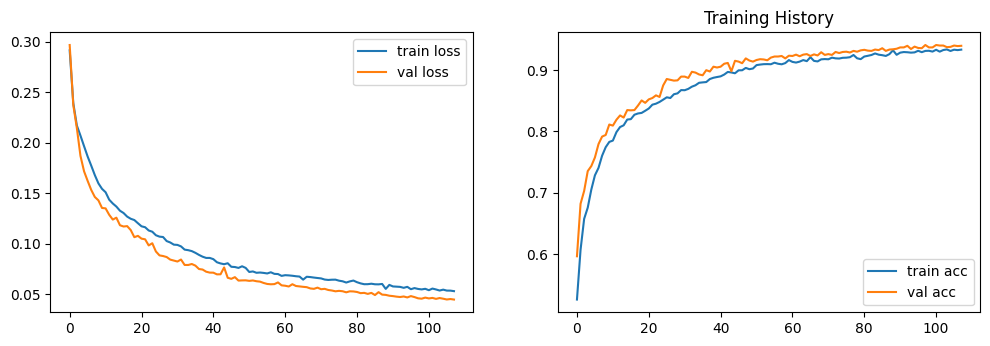

In [9]:
from core.viz import visualize_history

visualize_history(
    history,
    ["loss", "acc"]
)

Our model also seems to perform quite well on entirely new signs:

In [10]:
# And evaluate the model on test data
loss, acc = siamese_snn.evaluate([x_test_1, x_test_2], labels_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.1187 acc=0.8486


We can also reframe the test problem.

Previously we judged our model's capability to output a similarity score below 0.5 for matching samples and a score above 0.5 for non-matching ones.

How about we test our model's classification capabilities?
Given a number of possible classes (reference samples), which class does a given sample belong to?

In [11]:
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate_classification(model, reference_samples, reference_labels, test_samples, test_labels):
    y_true= test_labels
    y_pred = []
    for test_sample, test_label in zip(test_samples, test_labels):
        x_test = np.array([test_sample for _ in reference_samples])
        pred = model.predict([reference_samples, x_test], verbose=0)
        pred_label_idx = np.argmin(pred)
        predicted_label = reference_labels[pred_label_idx]
        y_pred.append(predicted_label)
    return y_true, y_pred, accuracy_score(y_true, y_pred)

In [12]:
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)

x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

In [13]:
# x_test and y_test are still sorted by label
# -> use the first sample for each label as reference
label_change_indices = np.where(np.roll(y_test,1)!=y_test)[0]

reference_labels = np.take(y_test, label_change_indices)
test_labels = np.delete(y_test, label_change_indices)

reference_samples = np.take(x_test, label_change_indices, axis=0)
test_samples = np.delete(x_test, label_change_indices, axis=0)

While this approach is obviously less computationally efficient our accuracy score is still somewhat respectable.

However, it is also significantly lower than our similarity-accuracy and nowhere near our original >90% classification accuracy.

This might be due to the fact that the classification problem is much harder: The model now has to produce meaningfully different similarity scores for possibly very similar samples that belong to different classes.

In [14]:
y_true, y_pred, acc = evaluate_classification(
    siamese_snn,
    reference_samples, reference_labels,
    test_samples, test_labels
)

print(f'++++++++++++ Test data (classification) ++++++++++++\nacc={acc:.4f}')

++++++++++++ Test data (classification) ++++++++++++
acc=0.8994


Looking at the confusion matrix, we can see a typical pattern: The model performs very well on "easy" pairings while it is little better than random for "hard" pairings ("easy" as in: solved well by the original classification model which was trained on the entire dataset; "hard": analogous).

Improving the model's ability to distinguish similar (hard) samples is a central problem of contrastive learning.

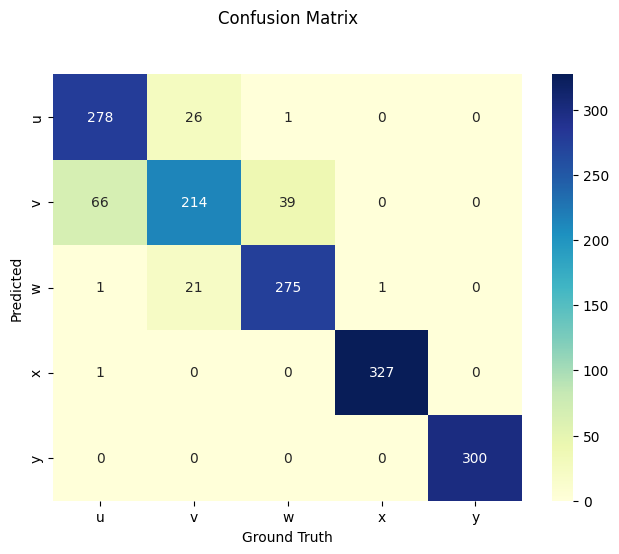

In [15]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(y_true, y_pred, str_test_labels)